In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df = pd.read_csv("C:/Users/miron/Downloads/KC19_d16t4_Safonov.csv", sep = ';')
df['14.42.43'] = df['14.42.43'] / 100

ccd = pd.read_csv("C:/Users/miron/Downloads/ccd_prosilica2.crv", sep = ' ')
ccd['X'] = ccd['X'] * 1000

a05 = pd.read_csv("C:/Users/miron/Downloads/a05.sp", sep = ' ')

# на данном этапе мы обрезаем значения файлов так, чтобы они покрывались всеми тремя файлами
tmp_min = np.max([ccd['X'][0], a05['X'][0], df['WAVE_LENGTH'][0]])
tmp_max = np.min([ccd['X'].iat[-1], a05['X'].iat[-1], df['WAVE_LENGTH'].iat[-1]])

df = df[df['WAVE_LENGTH'] < tmp_max]
X1 = df['WAVE_LENGTH'] * pow(10, -9) # [м]
Y1 = df['14.42.43']

ccd = ccd[ccd['X'] > tmp_min]
X2 = ccd['X'] * pow(10, -9) # [м]
Y2 = ccd['Y']

a05 = a05[a05['X'] > tmp_min]
X3 = a05['X'] * pow(10, -9) # [м]
Y3 = a05['Y'] 

max lambda: 107000.0 [нм]
шаг по длине волны: 1.07 [нм]


C:\Users\miron\AppData\Local\Temp\ipykernel_3848\2217007676.py:19: RuntimeWarning: invalid value encountered in true_divide
  res_fft = pow((np.imag(np.fft.fft(result/lambdas))), 2)


int F(λ): 0.9999999999999993


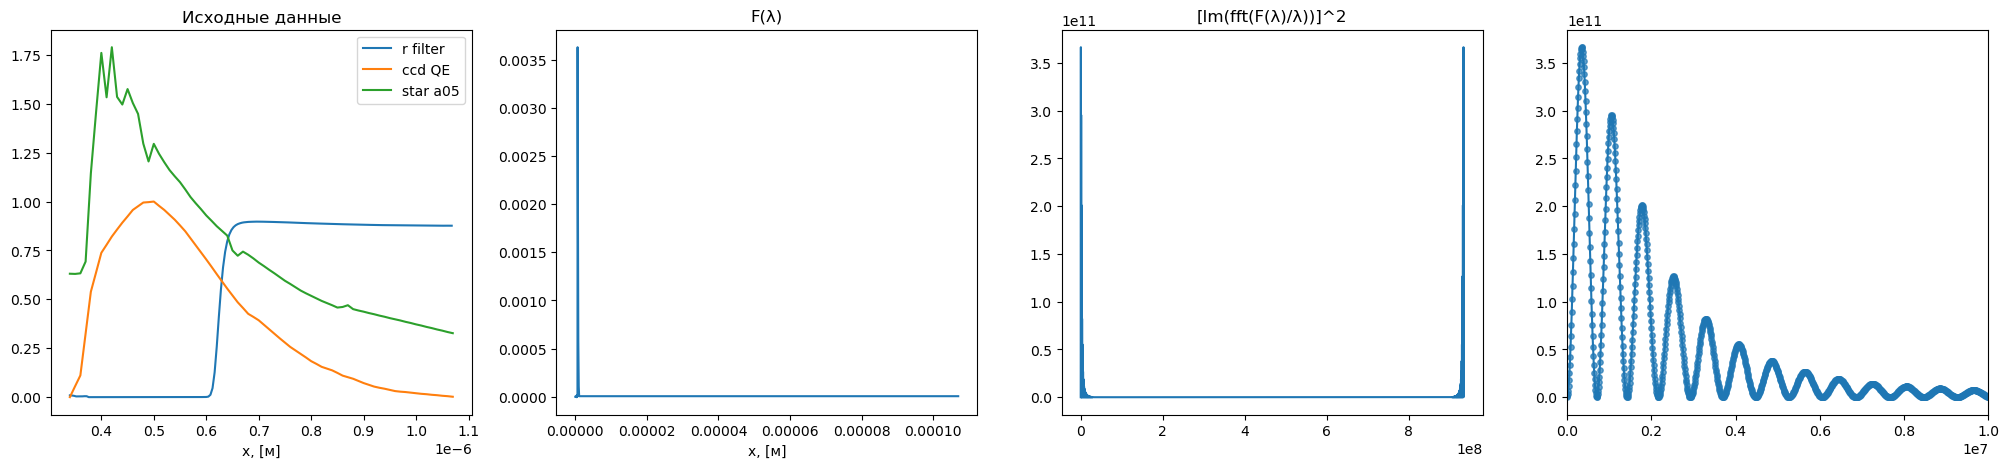

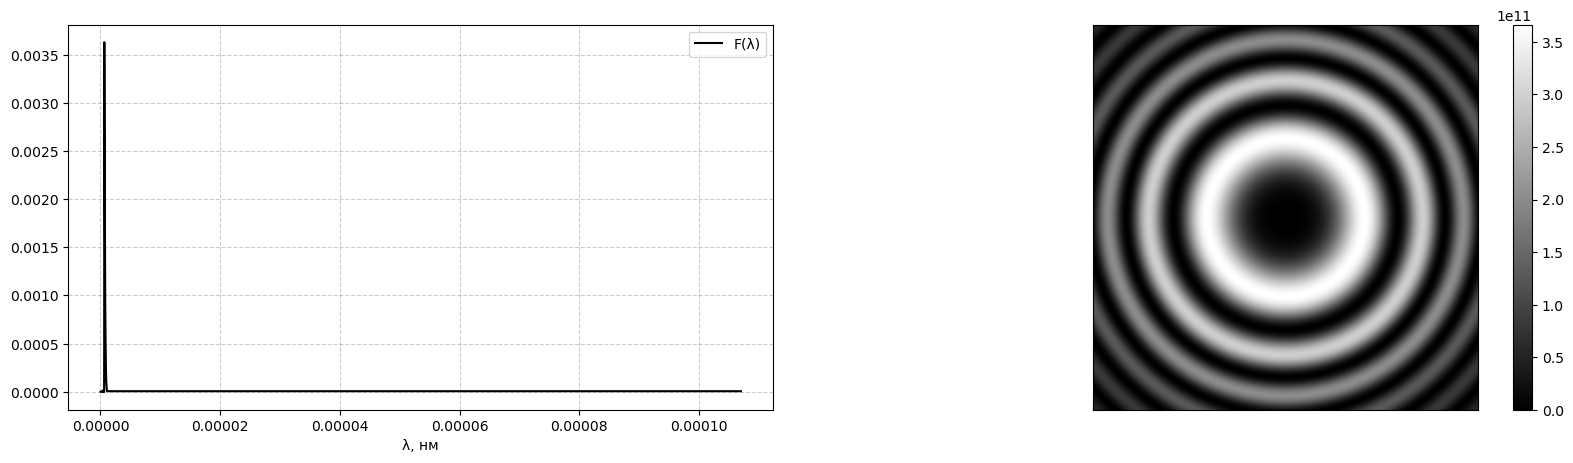

In [23]:
# т.к. разбивка по осям отличается, нужно свести их к одной, потому что далее мы будем перемножать значения, чтобы
# определить функцию спектрального отклика
coeff = 100
k = 1000*coeff
max_lambda = tmp_max*coeff
print('max lambda:', max_lambda, '[нм]')
print('шаг по длине волны:', max_lambda/k, '[нм]')
lambdas = np.linspace(0, max_lambda, k) * pow(10, -9) # [м]

interpolate_df = np.interp(lambdas, X1, Y1)
interpolate_ccd = np.interp(lambdas, X2, Y2)
interpolate_a05 = np.interp(lambdas, X3, Y3)
result = interpolate_df * interpolate_ccd * interpolate_a05
result = result/np.sum(result)

# мнимая часть Фурье преобразования от функции спектрального отклика
delta_lambdas = (max_lambda / len(lambdas)) * pow(10, -9) # период дискредизации, [м]
omega_lambdas_scale = 1 / (delta_lambdas) # максималльноешаг по частоте, [м^-1]
res_fft = pow((np.imag(np.fft.fft(result/lambdas))), 2)
# res_fft = list(res_fft)


res_fft_shifted = np.fft.fftshift(res_fft)

z = 2000 # дистанция распространения, [м]
nx =1000 # размер окна, [n_pix]
D = 2.5 # диаметр телескопа, [м]
D_pix = 228 # диаметр телескопа в пикселях, [n_pix]
delta = D/D_pix # шаг субапертуры, период дискретизации (то, насколько одно значение отстает от следующего) [м]
f_scale = 1/(delta*nx) # шаг по частоте, [м^-1]

xx, yy = np.meshgrid(np.linspace(-nx//2, nx//2-1, nx), np.linspace(-nx//2, nx//2-1, nx))
xx_scale = f_scale * xx 
yy_scale = f_scale * yy
f_abs = np.sqrt(pow(xx_scale, 2) + pow(yy_scale, 2))

omega = 0.5 * z * pow(f_abs, 2) # аргумент, шаг по частоте, [м^-1]
omega = np.ravel(omega)
omega_new = np.interp(omega, np.linspace(0, omega_lambdas_scale, k), res_fft)
omega_new = np.resize(omega_new, (1000, 1000))

# filter_ = np.interp(omega, lambdas, res_fft_shifted)
# filter_ = list(filter_)


fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(25, 5))

ax1.plot(X1, Y1, label = 'r filter')
ax1.plot(X2, Y2, label = 'ccd QE')
ax1.plot(X3, Y3, label = 'star a05')
ax1.legend()
ax1.set_title('Исходные данные')
ax1.set_xlabel('х, [м]')

ax2.plot(lambdas, result)
ax2.set_title('F(λ)')
ax2.set_xlabel('х, [м]')

ax3.plot(np.linspace(0, omega_lambdas_scale, k), res_fft)
ax3.set_title('[Im(fft(F(λ)/λ))]^2')

ax4.scatter(np.linspace(0, omega_lambdas_scale, k), res_fft, alpha=0.7, s=15)
ax4.plot(np.linspace(0, omega_lambdas_scale, k), res_fft)
ax4.set_xlim(xmax = 0.1*pow(10, 8))
ax4.set_xlim(xmin = 0*pow(10,8))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

fig.colorbar(ax2.imshow(omega_new, cmap='gray'), ax=ax2)
ax2.grid(False)
ax2.set_xticks([])
ax2.set_yticks([])

ax1.plot(lambdas, result, c='black', label='F(λ)')
ax1.set_xlabel('λ, нм')
ax1.legend()
ax1.grid(color = 'black', linestyle='--', alpha = 0.2)

fig.savefig('C:/astro/Response_func2.png', bbox_inches='tight')
print('int F(λ):', np.sum(result))

# fig.savefig('C:/astro/Response_func.png', bbox_inches='tight')

период дискредизации, [м]: 1e-09
максимальное значение по частоте, [м^-1]: 999999999.9999999


C:\Users\miron\AppData\Local\Temp\ipykernel_10396\387735093.py:19: RuntimeWarning: invalid value encountered in true_divide
  F_fft2 = pow((np.imag(np.fft.fft(F/lambdas))), 2)


(0.0, 10000000.0)

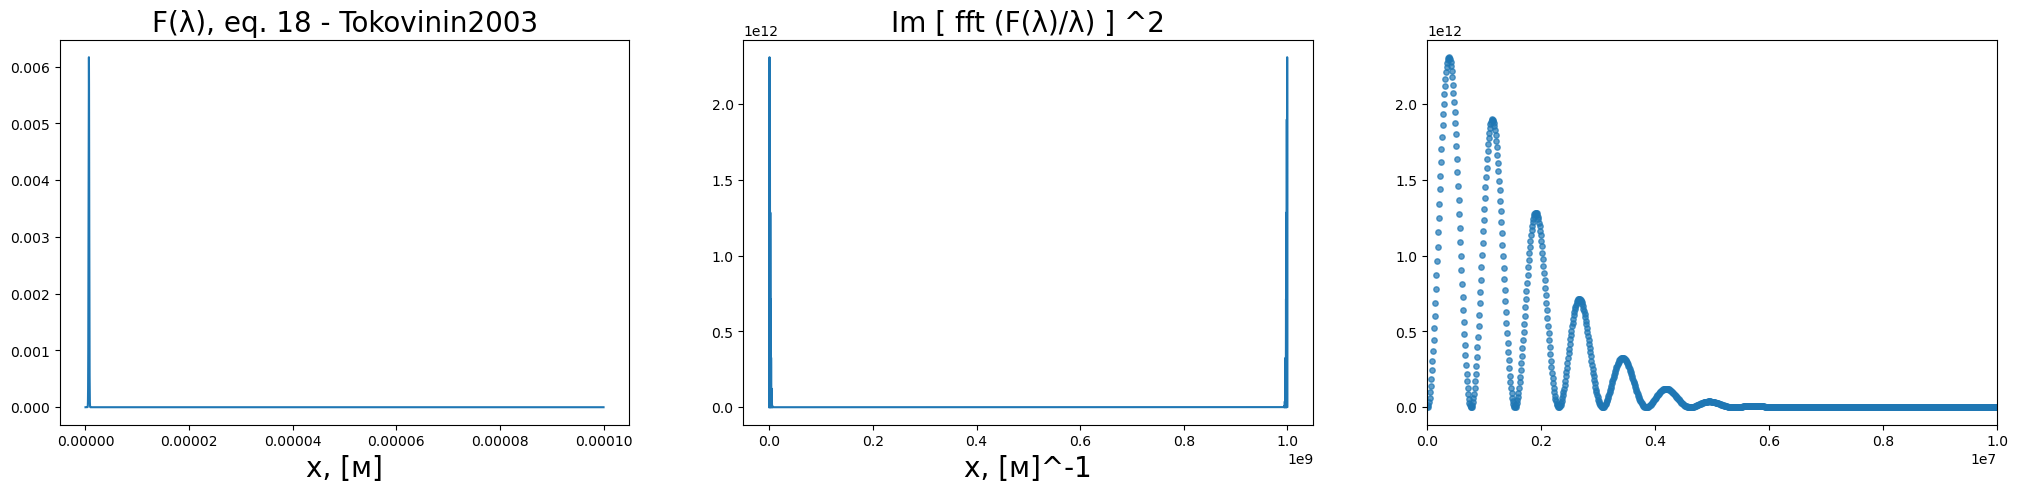

In [3]:
lambda_ = 650*pow(10, -9) # длина волны, [м]

max_lambda = 100000 # максимальное значение длины волны, [нм]
k = 100000

lambdas = np.linspace(0, max_lambda, k) * pow(10, -9) # длина волны, [м]
delta_lambdas = (max_lambda / len(lambdas)) * pow(10, -9) # период дискредизации, [м]
omega_lambdas_scale = 1 / (delta_lambdas) # максималльноешаг по частоте, [м^-1]

print('период дискредизации, [м]:', delta_lambdas)
print('максимальное значение по частоте, [м^-1]:', omega_lambdas_scale)

sigma = 65 * pow(10, -9) # FWHM = 2*sqrt(2*Ln(2))*sigma, [м]
a1 = (lambdas / lambda_) * (1 / (sigma * np.sqrt(2 * np.pi)))
a2 = np.exp( - pow(lambdas - lambda_, 2) / (2 * pow(sigma, 2)))
F = a1 * a2
F = F/np.sum(F) # нормировка для Фурье-преобразования
F_fft = np.fft.fft(F)
F_fft2 = pow((np.imag(np.fft.fft(F/lambdas))), 2)
 
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))

ax1.plot(lambdas, F)
ax1.set_title('F(λ), eq. 18 - Tokovinin2003', fontsize = 20)
ax1.set_xlabel('х, [м]', fontsize = 20)

ax2.plot(np.linspace(0, omega_lambdas_scale, k), F_fft2)
ax2.set_title('Im [ fft (F(λ)/λ) ] ^2', fontsize = 20)
ax2.set_xlabel('х, [м]^-1', fontsize = 20)

ax3.scatter(np.linspace(0, omega_lambdas_scale, k), F_fft2, alpha=0.7, s=15)
ax3.set_xlim(xmax = 0.01*pow(10,9))
ax3.set_xlim(xmin = 0*pow(10,9))

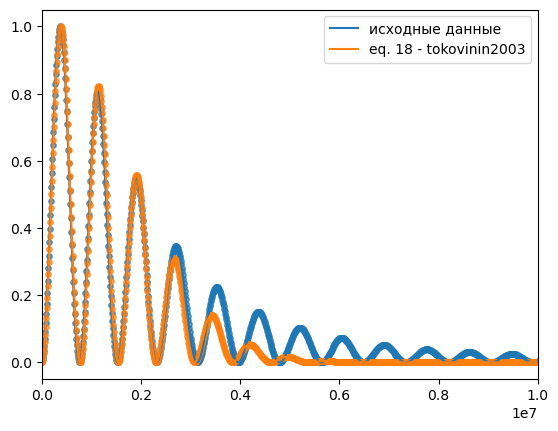

In [4]:
plt.figure()
plt.scatter(np.linspace(0, omega_lambdas_scale, k), res_fft/np.max(res_fft), alpha=0.7, s=15)
plt.plot(np.linspace(0, omega_lambdas_scale, k), res_fft/np.max(res_fft), label='исходные данные')
plt.scatter(np.linspace(0, omega_lambdas_scale, k), F_fft2/np.max(F_fft2), alpha=0.7, s=15)
plt.plot(np.linspace(0, omega_lambdas_scale, k), F_fft2/np.max(F_fft2), label='eq. 18 - tokovinin2003')
plt.xlim(xmax = 0.1*pow(10, 8))
plt.xlim(xmin = 0*pow(10,8))
plt.legend()
plt.savefig('C:/astro/1.png', bbox_inches='tight')

(0.0, 10000000.0)

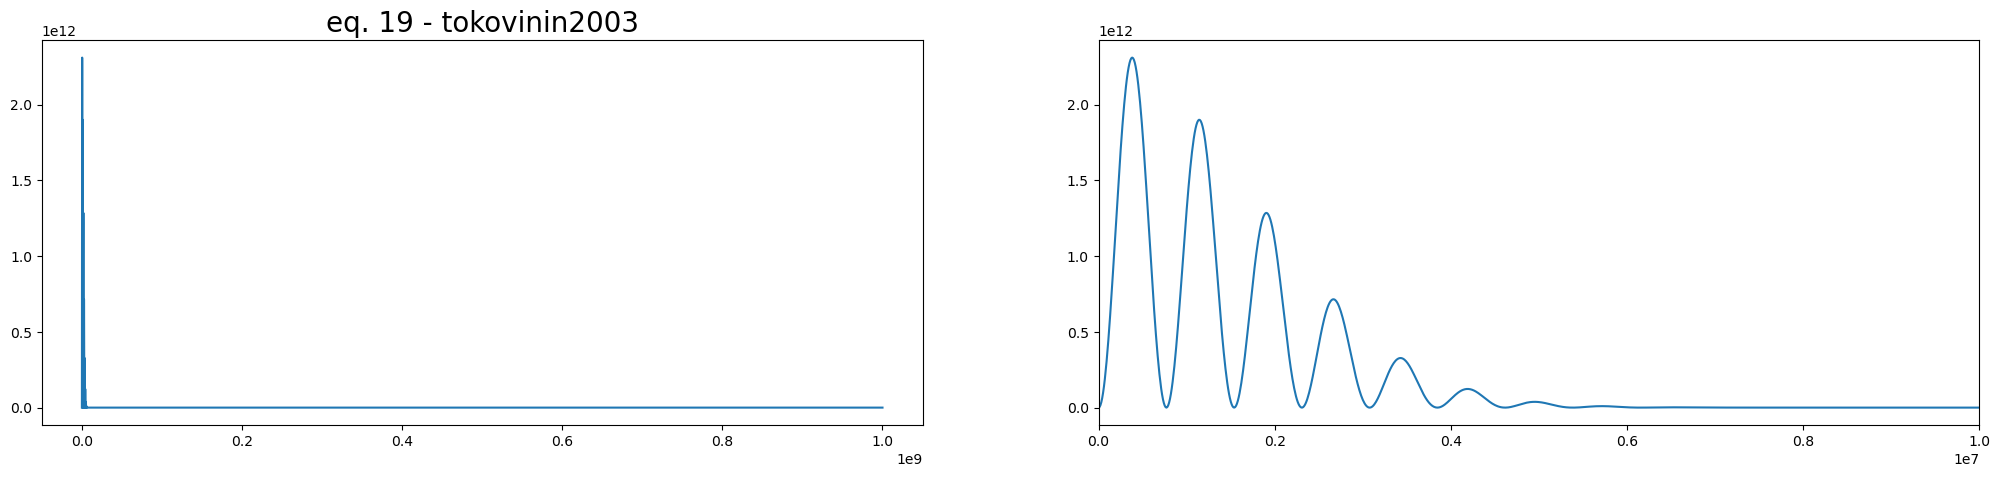

In [5]:
lambda_ = 650*pow(10, -9) # длина волны, [м]


max_lambda = 100000 # максимальное значение длины волны, [нм]
k = 100000

lambdas = np.linspace(0, max_lambda, k) * pow(10, -9) # длина волны, [м]
delta_lambdas = (max_lambda / len(lambdas)) * pow(10, -9) # период дискредизации, [м]
omega_lambdas_scale = 1 / (delta_lambdas) # максимальное значение по частоте, [м^-1]

a1 = 1 / lambda_
a2 = np.sin(2 * np.pi * lambda_ * np.linspace(0, omega_lambdas_scale, k))
a3 = np.exp(-2 * pow(np.pi, 2) * pow(sigma, 2) * pow(np.linspace(0, omega_lambdas_scale, k), 2))
f = pow(a1 * a2 * a3, 2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 5))

ax1.plot(np.linspace(0, omega_lambdas_scale, k), f)
ax1.set_title('eq. 19 - tokovinin2003', fontsize = 20)

ax2.plot(np.linspace(0, omega_lambdas_scale, k), f)
ax2.set_xlim(xmax = 0.1*pow(10, 8))
ax2.set_xlim(xmin = 0*pow(10,8))

Text(0.5, 1.0, 'eq. 20 - tokovinin2003')

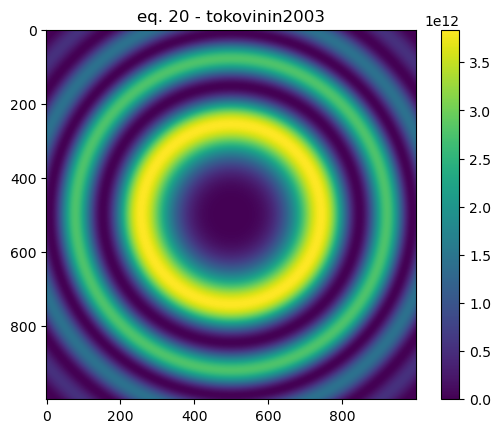

In [6]:
nx = 1000 # размер окна, [n_pix]
D = 2.5 # диаметр телескопа, [м]
D_pix = 228 # диаметр телескопа в пикселях, [n_pix]
lambda_ = 500*pow(10, -9) # длина волны, [м]
delta = D/D_pix # шаг субапертуры, период дискретизации (то, насколько одно значение отстает от следующего) [м]
z = 2000 # дистанция распространения, [м]
f_scale = 1/(delta*nx) # шаг по частоте, [м^-1]

xx, yy = np.meshgrid(np.linspace(-nx//2, nx//2-1, nx), np.linspace(-nx//2, nx//2-1, nx))
fx = f_scale * xx 
fy = f_scale * yy
f_abs = fx**2 + fy**2

sigma = 65 * pow(10, -9) # FWHM = 2*sqrt(2*Ln(2))*sigma, [м]
a1 = np.exp(- pow(np.pi, 2) * pow(z, 2) * pow(f_abs, 2) * pow(sigma, 2))
a2 = pow(np.sin(np.pi*z*lambda_*(f_abs)), 2)
a3 = pow(lambda_, -2)
S = a1 * a2 * a3 

plt.figure()
plt.imshow(S)
plt.colorbar()
plt.grid(False)
plt.title('eq. 20 - tokovinin2003')

In [7]:
# ccd = pd.read_csv("C:/Users/miron/Downloads/ccd_prosilica2.crv", sep = ' ')
# ccd

In [8]:
# a05 = pd.read_csv("C:/Users/miron/Downloads/a05.sp", sep = ' ')
# a05

In [9]:
# result = a05 * ccd
# result